methodNdx =
     2
     7
    13
indexOfDataToExtract =
  Columns 1 through 13
     2     5     6     8    14    15    21    27    28    30    31    34    36
  Columns 14 through 26
    40    42    44    45    46    48    51    55    56    57    69    77    78
  Columns 27 through 39
    79    93    94    95   104   105   108   111   112   114   117   122   124
  Columns 40 through 52
   129   131   141   143   155   156   157   158   159   164   165   166   170
  Columns 53 through 61
   172   177   178   182   186   192   194   197   199
relevantElements =
   122
A_RMSE =
    0.0779
D_RMSE =
    0.0167
precision =
    0.9672
recall =
    0.4836
relevantElements =
   122   122
A_RMSE =
    0.0779    0.0685
D_RMSE =
    0.0167    0.0150
precision =
    0.9672    0.6721
recall =
    0.4836    0.6721
relevantElements =
   122   122   122
A_RMSE =
    0.0779    0.0685    0.0662
D_RMSE =
    0.0167    0.0150    0.0158
precision =
    0.9672    0.6721    0.5355
recall =
    0.4836    0.6721

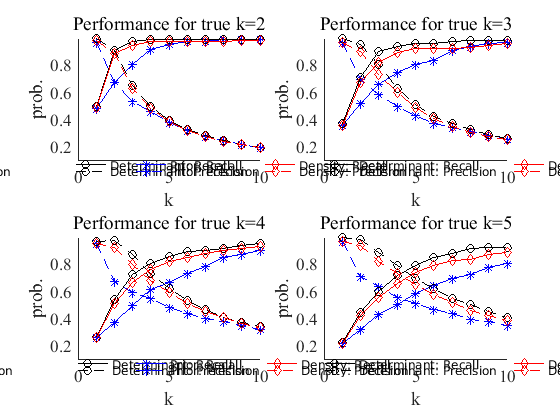

In [1]:
% evaluate for duration 18 sec.
clear all; clf
cd /home/jacob/panning_project/test_programs/
% GOD --> load test_MMDL_40iter_4April_dur_18sec.mat
%load test_MMDL_40iter_findfejl_27March_dur_18sec.mat
%load mats/sep2017/test_SQAM_diagonal_morenoisy_k25.mat
%load mats/sep2017/test_SQAM_diagonal_noisy_k25_250x12.mat
%load mats/sep2017/test_IOWA_diagonal_250samples_k25.mat
%load mats/sep2017/test_SQAM_diagonal_250samples_k35_non-contra.mat
%load mats/sep2017/test_IOWA_diagonal_250samples_k35_non-contra.mat

%%%%%%%%%%%%%%% ONLY For QDC method %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%load('mats/sep2017/test_IOWA_QDCdiagonal_250samples_k35_110iter.mat');

% ms(:,2:3)': prior based, 
% ms(:,7:8)', determinant based
% ms(:,13:14)': ICD based, 
methodNdx = [2;7;13]
for methodNumber = 1:3
load('mats/sep2017/test_IOWA_QDCdiagonal_250samples_k35_200iter.mat');


% test for true number of clusters
for kTrue = 2:5
thrForCorrect = 0.5; % both for angle(degrees) and samples(delay)

% define true number of clusters
for ii=1:size(muSorted,2)
    trueNumClusters(ii) = size(trueParameters{ii},1);
end
% extract all data corresponding to the true number of clusters
clusterMask = (trueNumClusters==kTrue);
indexOfDataToExtract = find(clusterMask)
for ii=1:sum(clusterMask)
    trueParametersByTrueClusters{ii} = trueParameters{indexOfDataToExtract(ii)};
    muSelectedByTrueClusters{ii} = muSelected{indexOfDataToExtract(ii)};
    muSortedByTrueClusters{ii} = muSorted{indexOfDataToExtract(ii)};
end


kVec=1:10;
for k=kVec
    saved.trueParams = trueParametersByTrueClusters;
    saved.X=trueParametersByTrueClusters; 
    for hh=1:size(muSortedByTrueClusters,2)
        ms = muSortedByTrueClusters{hh}; 
        saved.muPruned{hh} = ms(1:k,methodNdx(methodNumber):methodNdx(methodNumber)+1)'; % ms(:,13:14)': ICD based, ms(:,2:3)': prior based, ms(:,7:8)', determinant based
        saved.trueNumSource{hh} = size(trueParametersByTrueClusters{hh},1);
        saved.kPruned{hh} = size(saved.muPruned{hh},2);
    end
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    % evaluation
    [errorAngle, errorDelay,trueNumClusters,estimatedNumClusters,errorRateModelOrder,totalEstimatedParamsPruned, trueMinusEstimated] ...
        = evaluate_overfitting_precision_recall(saved,thrForCorrect);

    correctMask=(errorAngle<thrForCorrect) & (errorDelay<thrForCorrect);
    correctAmplitudes = errorAngle(correctMask);
    correctDelay = errorDelay(correctMask);

    relevantElements(k) = sum(trueNumClusters)
    %numCorrectParamEstimates = length(correctAmplitudes)
    %parameterPercentage = numCorrectParamEstimates/relevantElements;

    A_RMSE(k)=sqrt(mean(correctAmplitudes.^2))
    D_RMSE(k)=sqrt(mean(correctDelay.^2))

    % Precision Recall
    truePositives(k) = sum(correctMask);
    falsePositives(k) = sum(estimatedNumClusters)-truePositives(k);
    precision(k) =  truePositives(k)/(truePositives(k)+falsePositives(k))
    recall(k) = truePositives(k)/relevantElements(k)
    clear estimatedNumClusters correctMask correctAmplitudes correctDelay errorAngle errorDelay ms
end
prec(:,methodNumber,kTrue) = precision';
recll(:,methodNumber,kTrue) = recall';
clear precision recall
end
end

% plot results
figure(1);
for kTrue=2:5
subplot(2,2,kTrue-1); hold on;
title(sprintf('Performance for true k=%1.0f',kTrue))
        h1=plot(kVec,recll(:,1,kTrue),'b-*',kVec,prec(:,1,kTrue),'b--*', ...
                kVec,recll(:,2,kTrue),'k-o',kVec,prec(:,2,kTrue),'k--o',...
                kVec,recll(:,3,kTrue),'r-d',kVec,prec(:,3,kTrue),'r--d');
        xlabel('k'); ylabel('prob.'); ylim([0.1 1])
columnlegend(3,{'Prior: Recall','Prior: Precision','Determinant: Recall','Determinant: Precision','Density: Recall','Density: Precision'},'location','south');
end
